### Phase 4, Modelling

## Random Forest
- voi tunnistaa korrelaatioita, jotka eivät ole lineaarisia tai eivät välttämättä löydy nopeilla korrelaatioanalyyseillä
- Harjoittelumalli toteuttu datan 300 000 ensimmäisellä rivillä (eli noin 160 000, kun uudet autot poistetaan datasetistä)



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error, explained_variance_score, median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew

### Random Forest -mallin ensimmäinen toteutus


In [2]:
df = pd.read_csv('git/aida-project-template-autumn-2024/used_cars_data_ML.csv')

### Outlierit / skewness (vinous)
- Pelkällä outlierien pudottamisella päästään jo hyviin tuloksiin
- Pyritään silti parantamaan mallia ensimmäisen ajon jälkeen

In [3]:
# Skewness before
original_skewness = skew(df['price'])
print(f"Datan vinous ennen outlierin pudottamista: {original_skewness}")
print(f"Alkuperäinen koko: {len(df)}")

# Drop outliers
lower_bound = df['price'].quantile(0.01)
upper_bound = df['price'].quantile(0.99)
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

print(f"Suodatettu koko: {len(df)}")
# Skewness after
filtered_skewness = skew(df['price'])
print(f"Datan vinous outlierien pudottamisen jälkeen: {filtered_skewness}")

Datan vinous ennen outlierin pudottamista: 48.662936226481285
Alkuperäinen koko: 161641
Suodatettu koko: 158477
Datan vinous outlierien pudottamisen jälkeen: 0.9589953001796392


### Datan jakaminen ja mallin koulutus


In [4]:
X = df.drop(columns=['price'])  # Features
y = df['price']  # Target

# Training / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

### Mallin arviointi


In [5]:
# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

R² Score: 0.9492909353705488
Mean Absolute Error (MAE): 1569.9261715610733
Mean Absolute Percentage Error (MAPE): 8.61%


### Cross-validation

- Jakaa datan useaan osaan ja testaa datan käyttäen aina eri osia oppimiseen ja testaamiseen
- Mitä isompi R² ja mitä pienempi poikkeama, sitä luotettavampi malli on
  - R² kertoo kuinka suuren osan tuloksista malli osaa selittää, eli kuinka hyvin malli sopii dataan
  - Poikkeama kertoo R² arvon muutoksesta testien välillä
- R²: 0.9326 ± 0.0074 on mielestäni hyvä tulos, eli en lähde sen perusteella tekemään muutoksia


In [6]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X, y, cv=3, scoring='r2', n_jobs=-1)
print(f"Cross-validated R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validated R²: 0.9326 ± 0.0074


### Tarkastellaan eri ominaisuuksien vaikutusta mallintamiseen
- Tulosten perusteella voidaan pudottaa ominaisuuksia dataframesta
- En kuitenkaan päätynyt pudottamaan mitään, koska ominaisuuksien pudottaminen laski R² arvoa
  - Vaikutus oli muutenkin hyvin pieni
  

In [7]:
# Get feature importances
feature_importances = rf.feature_importances_
features = X.columns

# Create a DataFrame to sort and analyze feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set the threshold
threshold = 0.01
low_importance_features = importance_df[importance_df['Importance'] < threshold]['Feature']
print("Features to drop:", low_importance_features.tolist())

Features to drop: ['make_name_encoded', 'daysonmarket', 'seller_rating', 'body_type_encoded', 'engine_type_encoded', 'power_rpm', 'Sunroof/Moonroof', 'highway_fuel_economy', 'Navigation System', 'maximum_seating', 'city_fuel_economy', 'Heated Seats', 'fuel_type_encoded', 'listing_color_encoded', 'Leather Seats', 'franchise_dealer', 'Blind Spot Monitoring', 'Backup Camera', 'Adaptive Cruise Control', 'transmission_encoded', 'owner_count', 'Remote Start', 'Alloy Wheels', 'Parking Sensors', 'Bluetooth', 'has_accidents', 'fleet', 'CarPlay', 'isCab', 'Android Auto', 'frame_damaged']


In [8]:
importance_df

,Feature,Importance
8,horsepower,0.372730
17,year,0.310075
12,mileage,0.092920
41,wheel_system_encoded,0.030703
19,torque_rpm,0.020976
10,length,0.017593
39,model_name_encoded,0.014459
18,torque_value,0.014406
5,fuel_tank_volume,0.014214
16,width,0.013021


In [9]:
X_filtered = X.drop(columns=low_importance_features)

# Split the filtered data
X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

# Retrain the model
rf_filtered = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_filtered.fit(X_train_filtered, y_train)

# Evaluate the filtered model
y_pred_filtered = rf_filtered.predict(X_test_filtered)
r2_filtered = r2_score(y_test, y_pred_filtered)
mape_filtered = mean_absolute_percentage_error(y_test, y_pred_filtered)
print(f"R² poiston jälkeen: {r2_filtered}")
print(f"Mean Absolute Percentage Error (MAPE) poiston jälkeen: {mape_filtered * 100:.2f}%")

R² poiston jälkeen: 0.9293286170228988
Mean Absolute Percentage Error (MAPE) poiston jälkeen: 10.15%


### Hyperparametrien säätäminen GridSearchCV:n avulla
- GridSearchCV kouluttaa mallia useampaan kertaan ja etsii parhaat parametrit mallin ajoon
- Tämä ei kuitenkaan takaa sitä, että malli toimisi paremmin
  - Jos malli paranee vain hieman, on syytä miettiä, kannattaako mallia monimutkaistaa vain pienen parannuksen takia
  - Jos malli toimii hyvin pienillä säädöillä, se voi kertoa mallin vakaudesta ja hyvästä datan esikäsittelystä
- Tekemäni testin perusteella GridSearchista ei ollut hyötyä, joten en muuttanut mallia


In [10]:
# Parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Parhaat parametrit:", grid_search.best_params_)
tuned_rf = grid_search.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Parhaat parametrit: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [11]:
# Tuned model with "best" parameters
tuned_rf = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

tuned_rf.fit(X_train, y_train)
y_pred = tuned_rf.predict(X_test)

# Evaluate the tuned model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Uuden mallin arviointi")
print(f"R²: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

Uuden mallin arviointi
R²: 0.9479805450265617
Mean Absolute Error (MAE): 1610.3070597805038
Mean Absolute Percentage Error (MAPE): 8.82%


### Random Forest -mallin lopullinen toteutus
- Käytössä koko datasetti, eli noin 1,5 miljoonaa riviä, kun datasta on poistettu uudet autot

In [12]:
df = pd.read_csv('git/aida-project-template-autumn-2024/used_cars_data_ML_ALL.csv')

### Outlierit / skewness (vinous)

In [13]:
# Skewness before
original_skewness = skew(df['price'])
print(f"Datan vinous ennen outlierin pudottamista: {original_skewness}")
print(f"Original dataset size: {len(df)}")

# Drop outliers
lower_bound = df['price'].quantile(0.01)
upper_bound = df['price'].quantile(0.99)
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

print(f"Filtered dataset size: {len(df)}")
# Skewness after
filtered_skewness = skew(df['price'])
print(f"Datan vinous outlierien pudottamisen jälkeen: {filtered_skewness}")

Datan vinous ennen outlierin pudottamista: 30.312652328298636
Original dataset size: 1529003
Filtered dataset size: 1499187
Datan vinous outlierien pudottamisen jälkeen: 0.9913552799123803


### Datan jakaminen ja mallin koulutus


In [14]:
# Separate features (X) and target (y)
X = df.drop(columns=['price'])  # Features
y = df['price']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_final = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)

### Mallin arviointi


In [15]:
# Evaluate the final model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

R² Score: 0.9629869274717948
Mean Absolute Error (MAE): 1429.3623317152578
Mean Absolute Percentage Error (MAPE): 7.79%


### Vertailu testiajoon
- Lopullisessa ajossa oli n. 10 kertaa enemmän dataa testiajoon verrattuna
- R² Score: 0.949 -> 0.963
- Mean Absolute Error (MAE): 1569.93 -> 1429.36
- Mean Absolute Percentage Error (MAPE): 8.61% -> 7.79%



### Visualisointi


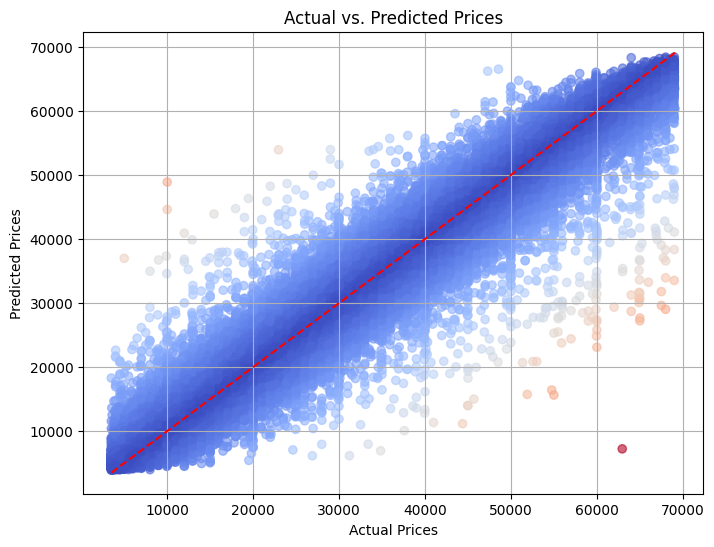

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, c=np.abs(y_test - y_pred), cmap='coolwarm')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

- Ennustus on onnistunut täydellisesti sen osueassa punaiselle viivalle
- Ennustukset ovat pääsääntöisesti onnistuneet hyvin, mutta hajontaa on varsinkin isommissa hinnoissa
  - Hajonta tarkoittaa luultavasti sitä, että malli ei osaa ennustaa kalliiden autojen hintoja hyvin
  - Datassa voi myös olla virheitä, jotka aiheuttavat hajontaa tuloksissa



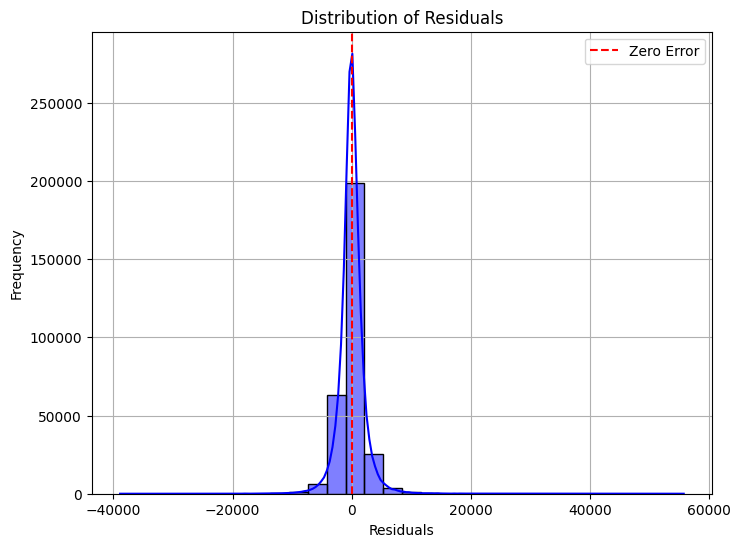

In [17]:
import seaborn as sns

residuals =  y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()



- [ Todellinen arvo - Ennustettu arvo = Jäännös (residual) ], eli jäännöksen ollessa 0, ennustus on onnistunut täydellisesti
- Mitä suurempi osa arvoista on nollassa tai sen läheisyydessä, sitä parempi


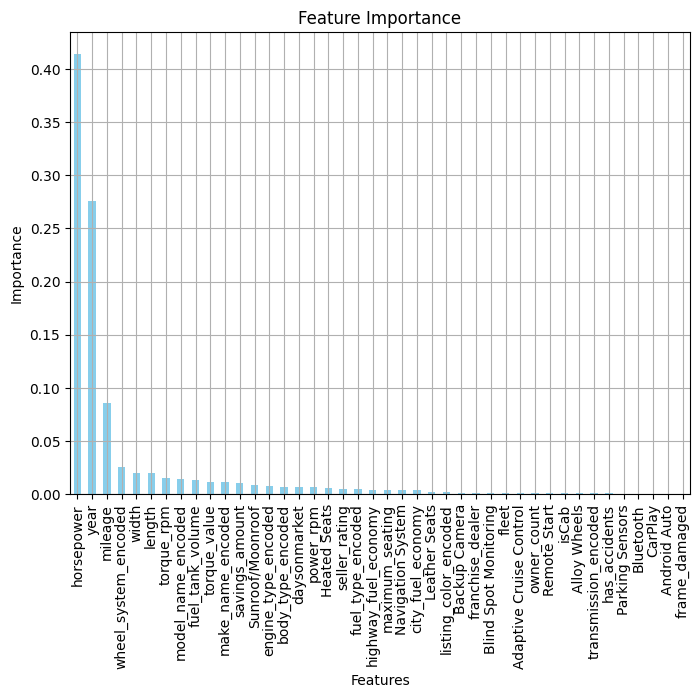

In [18]:
# Extract feature importances
feature_importances = pd.Series(rf_final.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.grid(True)
plt.show()

- Ominaisuuksien tärkeydessä on selvä kolmen kärki ja suurella osalla ominaisuuksista on hyvin pieni merkitys
- Ominaisuuksien pudottamisesta ei kuitenkaan ollut hyötyä, joten päätin jättää kaikkki ominaisuudet dataframeen
